In [2]:
import pandas as pd
from sklearn import linear_model
import os
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import numpy as np
from sklearn import metrics
import itertools
from sklearn.metrics import confusion_matrix
import pickle

In [3]:
def plotAUC(truth, pred, lab, stdErrData):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # stdErrData.append(tpr.tolist())
    # nparrayPlot = np.array(stdErrData)
    # stdabweichung = nparrayPlot.std(axis=0)
    
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    
    
    # plt.errorbar(fpr, tpr, yerr=stdabweichung, fmt='_')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")
    
    
    
def plot_confusion_matrix(y_test, model, label='', normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Funded", "Not Funded"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix: " + label
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def mappeDaten(dataset): 

    # Baue Datensatz auf
    data_with_funding_limit_sliced = dataset[(dataset['d_fundlim'] ==1) | (dataset['d_fundlim']==0)]
    
    # Dummy-Conversion
    di = {0:0, 1:1}   #converting target variable to boolean
    
    # Boolsches Ergebnis
    Dataset_withBoolTarget= data_with_funding_limit_sliced.replace({'d_fundlim': di})
    
    Dataset_withBoolTarget['d_fundlim'].value_counts()
    print("Current shape of dataset :",Dataset_withBoolTarget.shape)
    Dataset_withBoolTarget.head(3)
    
    
    # Loesche unnoetige Leerzeilen
    dataset=Dataset_withBoolTarget.dropna(thresh = 1,axis=1) #340000 is minimum number of non-NA values
    print("Current shape of dataset :",dataset.shape)
    
    
    # Waehle die Daten aus
    features = ['d_fundlim', 'p_selfemplexp', 'p_startupexp', 'p_foundhist', 'p_ttempl', 'p_leadexp', 'p_femfounder',
    'p_vocedu', 'p_bachelor', 'p_master', 'p_mba', 'p_phd', 'p_ttuni',
    'd_Patents_registered', 'd_Trademark', 'd_govgrant', 'd_awards',
    'n_network', 'd_expert', 'd_angel', 'd_academic',
    'n_picgraph', 'n_words', 'n_vidlength',
    'd_reward', 'plat', 'year_fund', 'location','bstage', 'conttype', 'equityoffer', 'comptype']
    
    
    Final_data = dataset[features] #19 features with target var
    #Final_data= Final_data.reset_index(drop=True)
    print("Current shape of dataset :",Final_data.shape)
    
    # Fuehre ein Mapping auf Integer-Werte durch
    Final_data['comptype'] = Final_data['comptype'].map({'GmbH':0,'UG':1})
    Final_data['location'] = Final_data['location'].map({'Muenchen':0,'Berlin':1,'Hamburg':2,'Other':3})
    Final_data['conttype'] = Final_data['conttype'].map({'shareholder subordinated loan':0,'silent partnership':1, 'shareholder loan ':2})
    Final_data['bstage'] = Final_data['bstage'].map({'start-up':0,'seed':1,'growth':2})
    Final_data['plat'] = Final_data['plat'].map({'seedmatch':0,'innovestment':1,'companisto':2})
    Final_data['year_fund'] = Final_data['year_fund'].map({2011:0,2012:1,2013:2,2014:3,2015:4})
    
    print("Current shape of dataset :",Final_data.shape)
    Final_data.head()
    
    # Fill missing feature (nothing there)
    Final_data.fillna(Final_data.mean(),inplace = True)
    HTML(Final_data.tail().to_html())
    print("Current shape of dataset :",Final_data.shape)
    
    # Clean data 
    scl = preprocessing.StandardScaler() #instance of preprocessing
    fields = Final_data.columns.values[1:]
    
    # Alle Spalten auf Gasu Verteilung gemappt
    data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
    
    # Binär Variablen werden wieder auf eins und null gesetzt
    data_clean['d_Patents_registered'] = Final_data['d_Patents_registered']
    data_clean['d_Trademark'] = Final_data['d_Trademark']
    data_clean['d_govgrant'] = Final_data['d_govgrant']
    data_clean['d_awards'] = Final_data['d_awards']
    data_clean['d_expert'] = Final_data['d_expert']
    data_clean['d_angel'] = Final_data['d_angel']
    data_clean['d_academic'] = Final_data['d_academic']
    data_clean['d_reward'] = Final_data['d_reward']
    data_clean['comptype'] = Final_data['comptype']
    data_clean['d_fundlim'] = Final_data['d_fundlim']
    data_clean['d_fundlim'].value_counts()
    
    
    #data_clean = data_clean.sample(frac=1).reset_index(drop=True)
    print("Current shape of dataset :",data_clean.shape)
    data_clean.head()
    data_clean.corr()
    
    return data_clean

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.00001, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def loadData():
    dataset1 = pd.read_excel('Basisdaten_20210721.xlsx')
    return dataset1

def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")


In [4]:
os.chdir(r"/home/mark/my_project/venv")
dataset1 = loadData()
# Mappe Daten auf Gauss-Verteilung und ordne kategorische Variablen einem Integer-Wert zu
data_clean = mappeDaten(dataset1)

Current shape of dataset : (163, 121)
Current shape of dataset : (163, 114)
Current shape of dataset : (163, 32)
Current shape of dataset : (163, 32)
Current shape of dataset : (163, 32)
Current shape of dataset : (163, 32)


/tmp/ipykernel_13006/2249650588.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_data['comptype'] = Final_data['comptype'].map({'GmbH':0,'UG':1})
/tmp/ipykernel_13006/2249650588.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_data['location'] = Final_data['location'].map({'Muenchen':0,'Berlin':1,'Hamburg':2,'Other':3})
/tmp/ipykernel_13006/2249650588.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [5]:
data_clean.to_excel('data_clean.xlsx', index = False)

0.7272727272727273


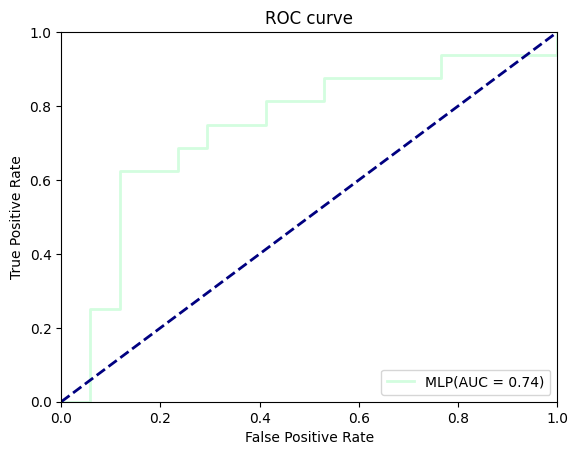

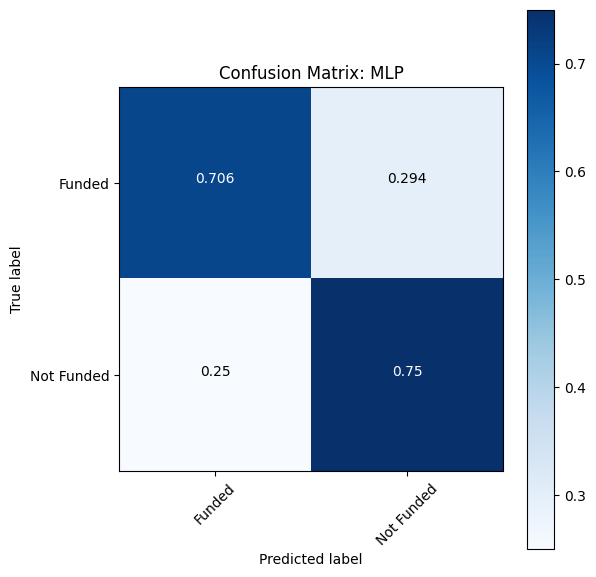

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42, stratify=data_clean.iloc[:,-1])

# MLP
clf_NN = MLPClassifier(activation='relu', solver='sgd', learning_rate='adaptive', alpha=0.05, hidden_layer_sizes=(46, 11), random_state=1, max_iter=5000)
clf_NN.fit(X_train,y_train)     
predict_NN = clf_NN.predict(X_test)
predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
print(NNAccuracy)

plotAUC(y_test,predictproba_NN,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(y_test, predict_NN, 'MLP', normalize=True)
plt.show()

<Figure size 1500x1000 with 0 Axes>

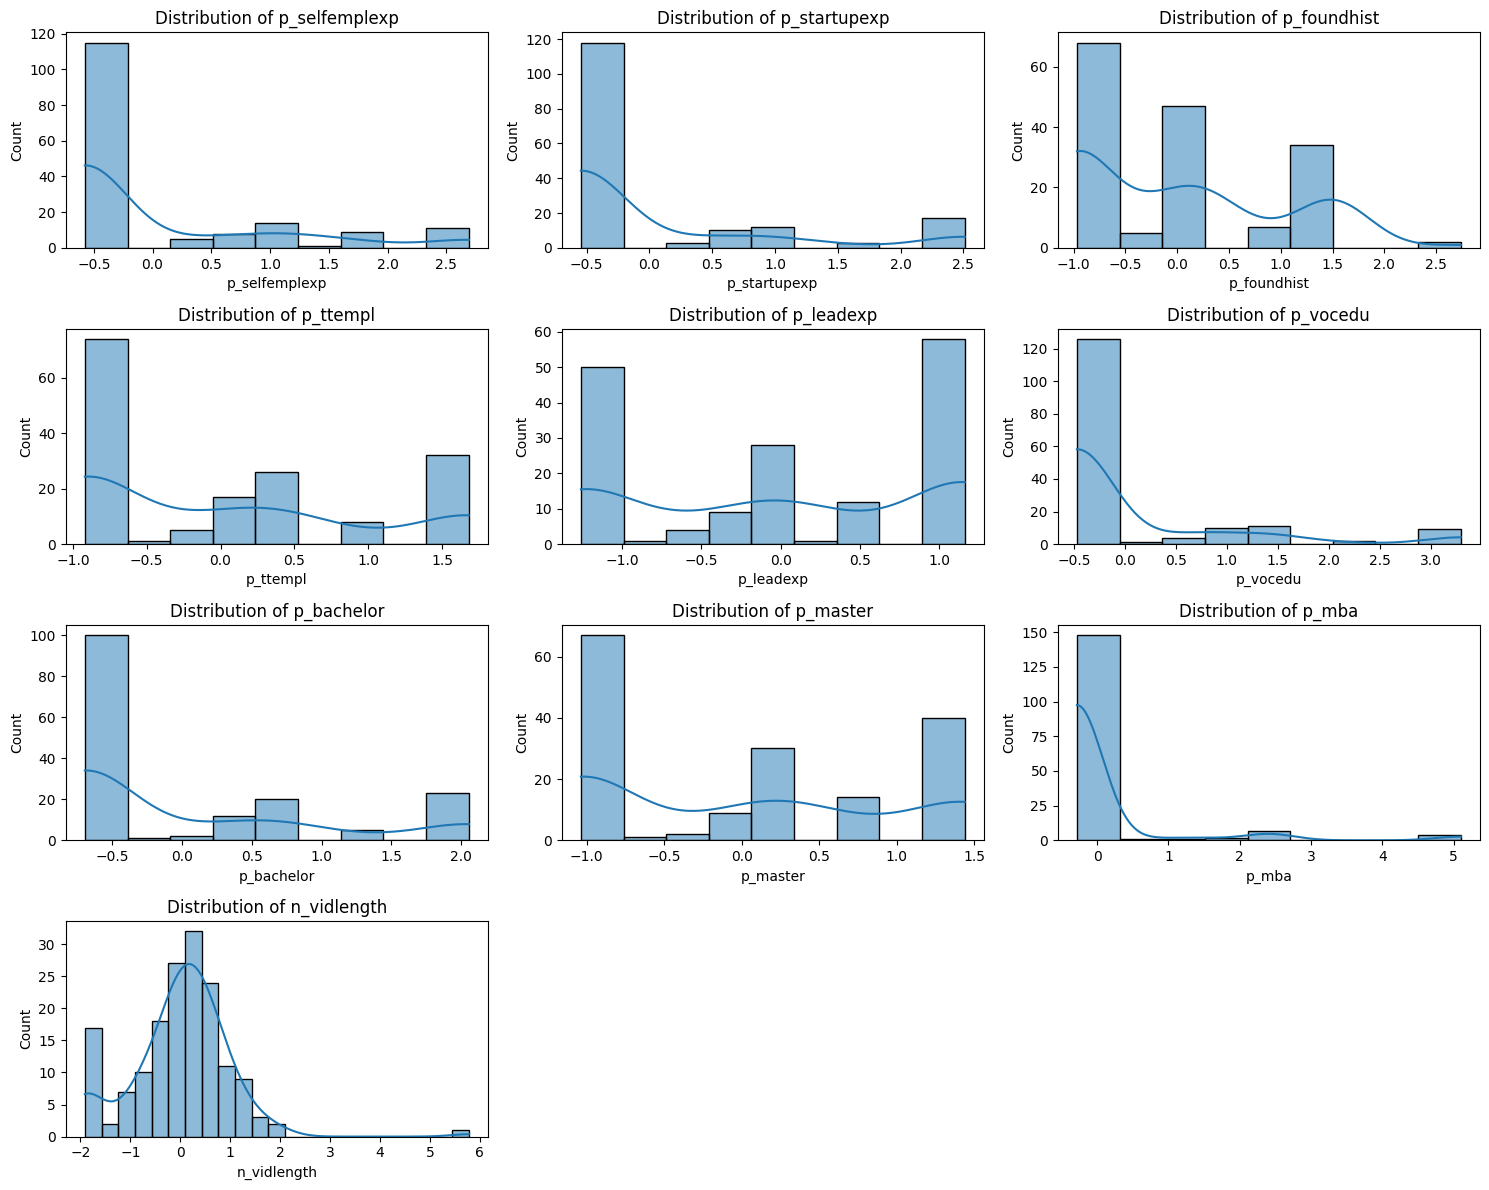

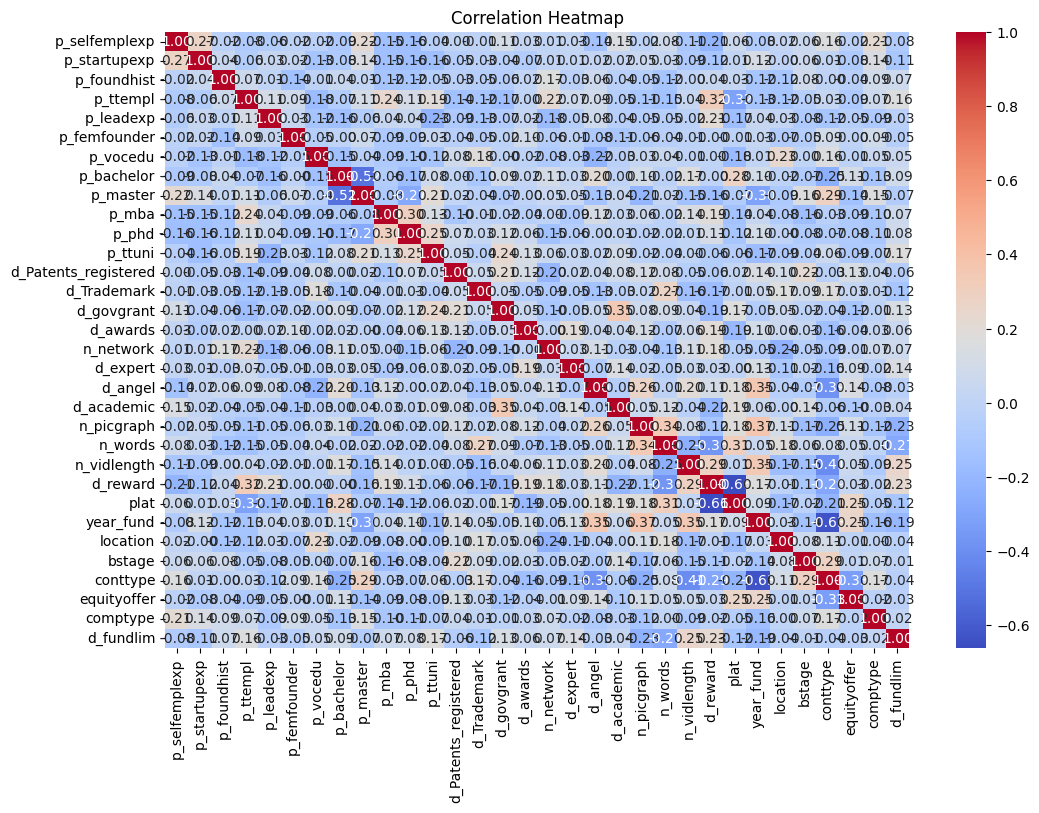

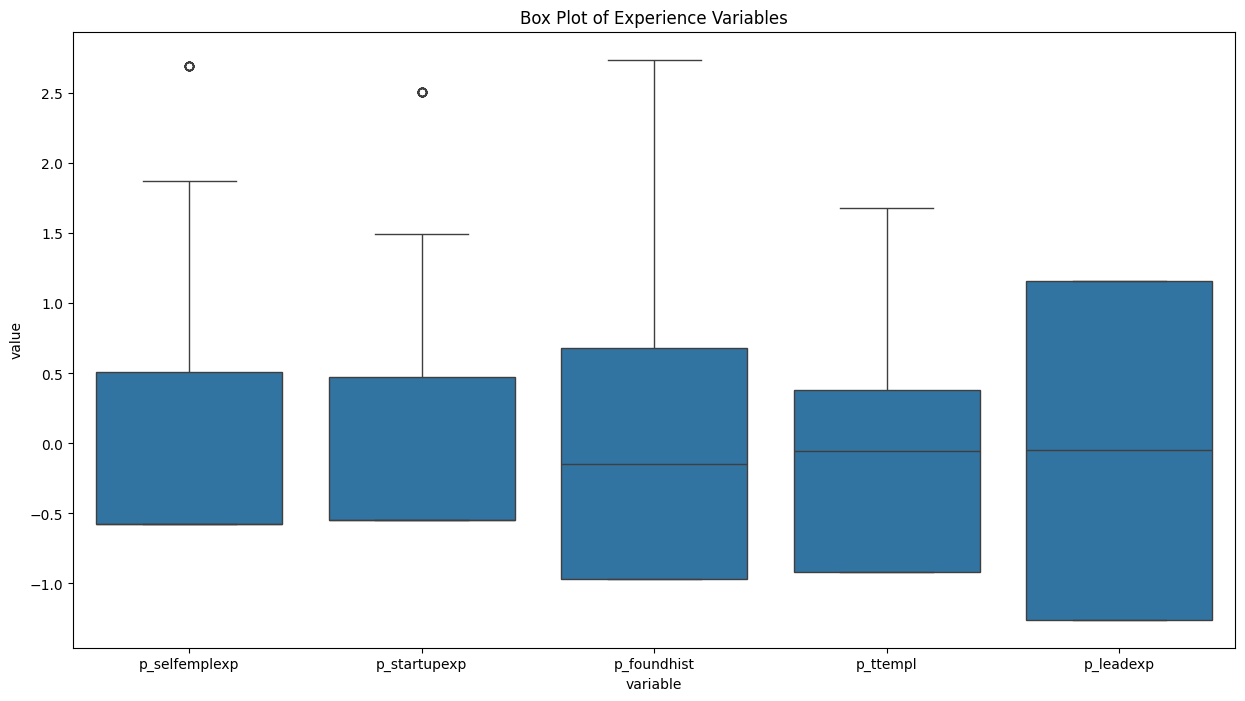

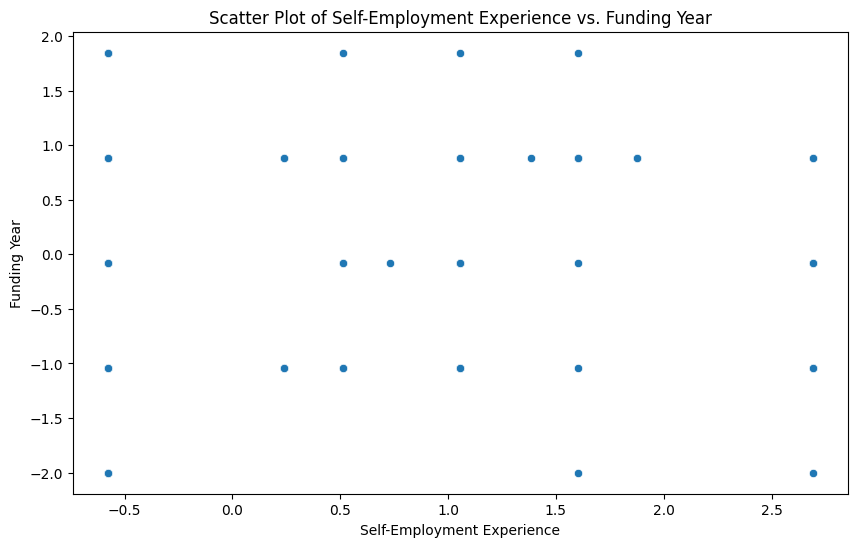

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

data = data_clean.copy()
# Set up the figure size for all plots
plt.figure(figsize=(15, 10))

# 1. Distribution of Key Variables (Histograms)
key_vars = ['p_selfemplexp', 'p_startupexp', 'p_foundhist', 'p_ttempl', 'p_leadexp',
            'p_vocedu', 'p_bachelor', 'p_master', 'p_mba', 'n_vidlength']

plt.figure(figsize=(15, 12))
for i, var in enumerate(key_vars, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data[var], kde=True)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# 3. Box Plots for Experience Variables
plt.figure(figsize=(15, 8))
experience_vars = ['p_selfemplexp', 'p_startupexp', 'p_foundhist', 'p_ttempl', 'p_leadexp']
data_melted = data.melt(value_vars=experience_vars)

sns.boxplot(x='variable', y='value', data=data_melted)
plt.title('Box Plot of Experience Variables')
plt.show()

# 4. Scatter Plot Example: Experience vs Funding Year
plt.figure(figsize=(10, 6))
sns.scatterplot(x='p_selfemplexp', y='year_fund', data=data)
plt.title('Scatter Plot of Self-Employment Experience vs. Funding Year')
plt.xlabel('Self-Employment Experience')
plt.ylabel('Funding Year')
plt.show()


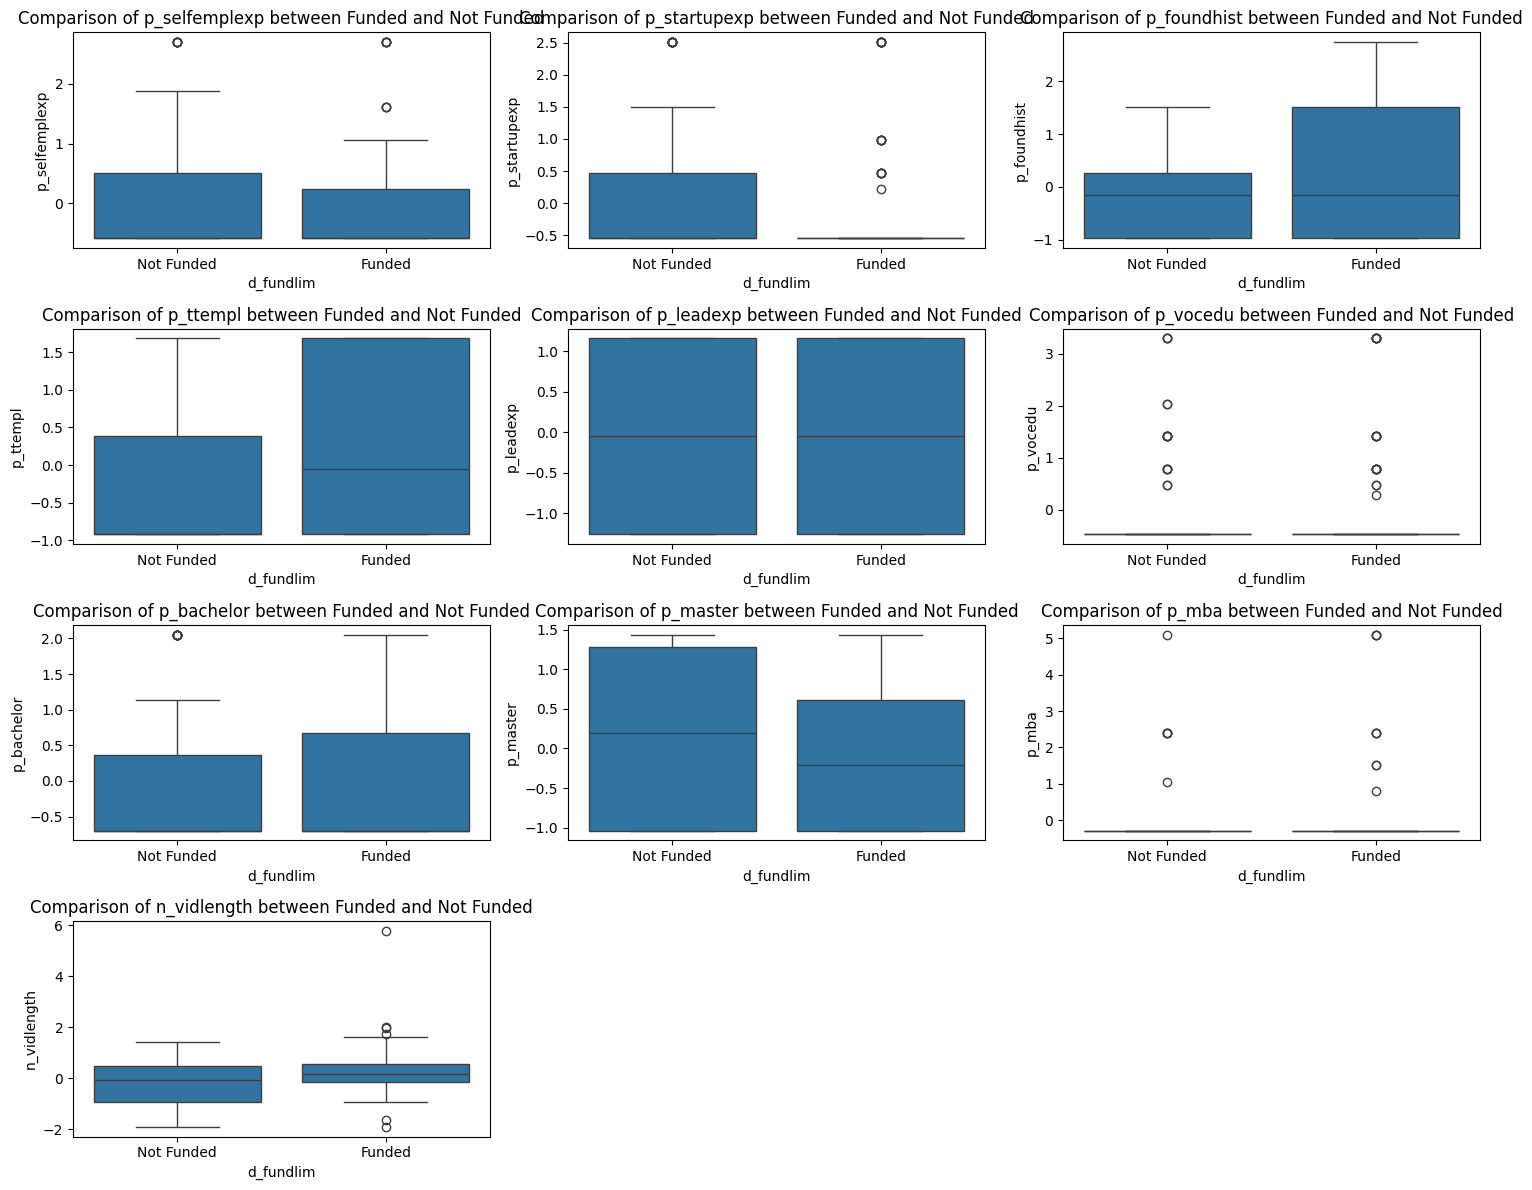

In [16]:


# Separate the data into two groups based on the dependent variable d_fundlim
funded = data[data['d_fundlim'] == 1]
not_funded = data[data['d_fundlim'] == 0]

# Generate summary statistics for both groups
funded_stats = funded.describe()
not_funded_stats = not_funded.describe()

# Combine the summary statistics for comparison
comparison_stats = pd.concat([funded_stats, not_funded_stats], axis=1, keys=['Funded', 'Not Funded'])

comparison_stats
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization: Comparing key variables between funded and not funded start-ups
key_vars = ['p_selfemplexp', 'p_startupexp', 'p_foundhist', 'p_ttempl', 'p_leadexp',
            'p_vocedu', 'p_bachelor', 'p_master', 'p_mba', 'n_vidlength']

plt.figure(figsize=(15, 12))
for i, var in enumerate(key_vars, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='d_fundlim', y=var, data=data)
    plt.title(f'Comparison of {var} between Funded and Not Funded')
    plt.xticks([0, 1], ['Not Funded', 'Funded'])
plt.tight_layout()
plt.show()


In [19]:
import statsmodels.api as sm


# Including all the variables from the dataset in the logistic regression model
X_all = data.drop(columns=['d_fundlim'])

# Adding a constant to the model
X_all = sm.add_constant(X_all)

# Dependent variable
y = data['d_fundlim']

# Fit the logistic regression model with all variables
logit_model_all = sm.Logit(y, X_all)
result_all = logit_model_all.fit()

# Display the model summary
model_summary_all = result_all.summary()
model_summary_all


Optimization terminated successfully.
         Current function value: 0.504066
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              d_fundlim   No. Observations:                  163
Model:                          Logit   Df Residuals:                      131
Method:                           MLE   Df Model:                           31
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                  0.2728
Time:                        23:58:08   Log-Likelihood:                -82.163
converged:                       True   LL-Null:                       -112.98
Covariance Type:            nonrobust   LLR p-value:                 0.0008626
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.4236      0.560     -2.541      0.011      -2.522      -0.325
p_selfemplexp            0.0367      0.219      0.168      0.867      -0.392       0.465
p_startupexp             0.1741      0.230      0.756      0.450      -0.277       0.626
p_foundhist              0.1450      0.221      0.657      0.511      -0.287       0.577
p_ttempl                 0.1636      0.229      0.716      0.474      -0.285       0.612
p_leadexp               -0.0414      0.236     -0.176      0.860      -0.503       0.420
p_femfounder             0.0052      0.216      0.024      0.981      -0.418       0.429
p_vocedu                 0.3553      0.250      1.418      0.156      -0.136       0.846
p_bachelor              -0.0089      0.308     -0.029      0.977      -0.612       0.595
p_master                -0.4038      0.330     -1.222      0.222      -1.052       0.244
p_mba                    0.1037      0.228      0.455      0.649      -0.343       0.550
p_phd                    0.0831      0.276      0.301      0.764      -0.459       0.625
p_ttuni                  0.3407      0.262      1.301      0.193      -0.172       0.854
d_Patents_registered    -0.0096      0.707     -0.014      0.989      -1.394       1.375
d_Trademark              0.0025      0.901      0.003      0.998      -1.763       1.768
d_govgrant               0.7156      0.612      1.170      0.242      -0.483       1.915
d_awards                 0.0775      0.487      0.159      0.874      -0.876       1.031
n_network               -0.0778      0.220     -0.354      0.724      -0.509       0.354
d_expert                 1.0333      0.436      2.372      0.018       0.179       1.887
d_angel                  0.1524      0.476      0.320      0.749      -0.780       1.085
d_academic               0.4235      0.675      0.627      0.531      -0.900       1.747
n_picgraph              -0.4560      0.271     -1.684      0.092      -0.987       0.075
n_words                 -0.4608      0.307     -1.500      0.134      -1.063       0.141
n_vidlength              0.7708      0.270      2.858      0.004       0.242       1.299
d_reward                 1.0555      0.699      1.509      0.131      -0.315       2.426
plat                     0.3543      0.376      0.942      0.346      -0.383       1.091
year_fund               -0.9594      0.325     -2.952      0.003      -1.596      -0.322
location                 0.2397      0.231      1.039      0.299      -0.212       0.692
bstage                   0.0906      0.223      0.407      0.684      -0.346       0.527
conttype                -0.1748      0.346     -0.505      0.614      -0.853       0.504
equityoffer              0.0526      0.215      0.245      0.807      -0.369       0.474
comptype                 0.0131      0.575      0.023      0.982      -1.113       1.140
========================================================================================
"""

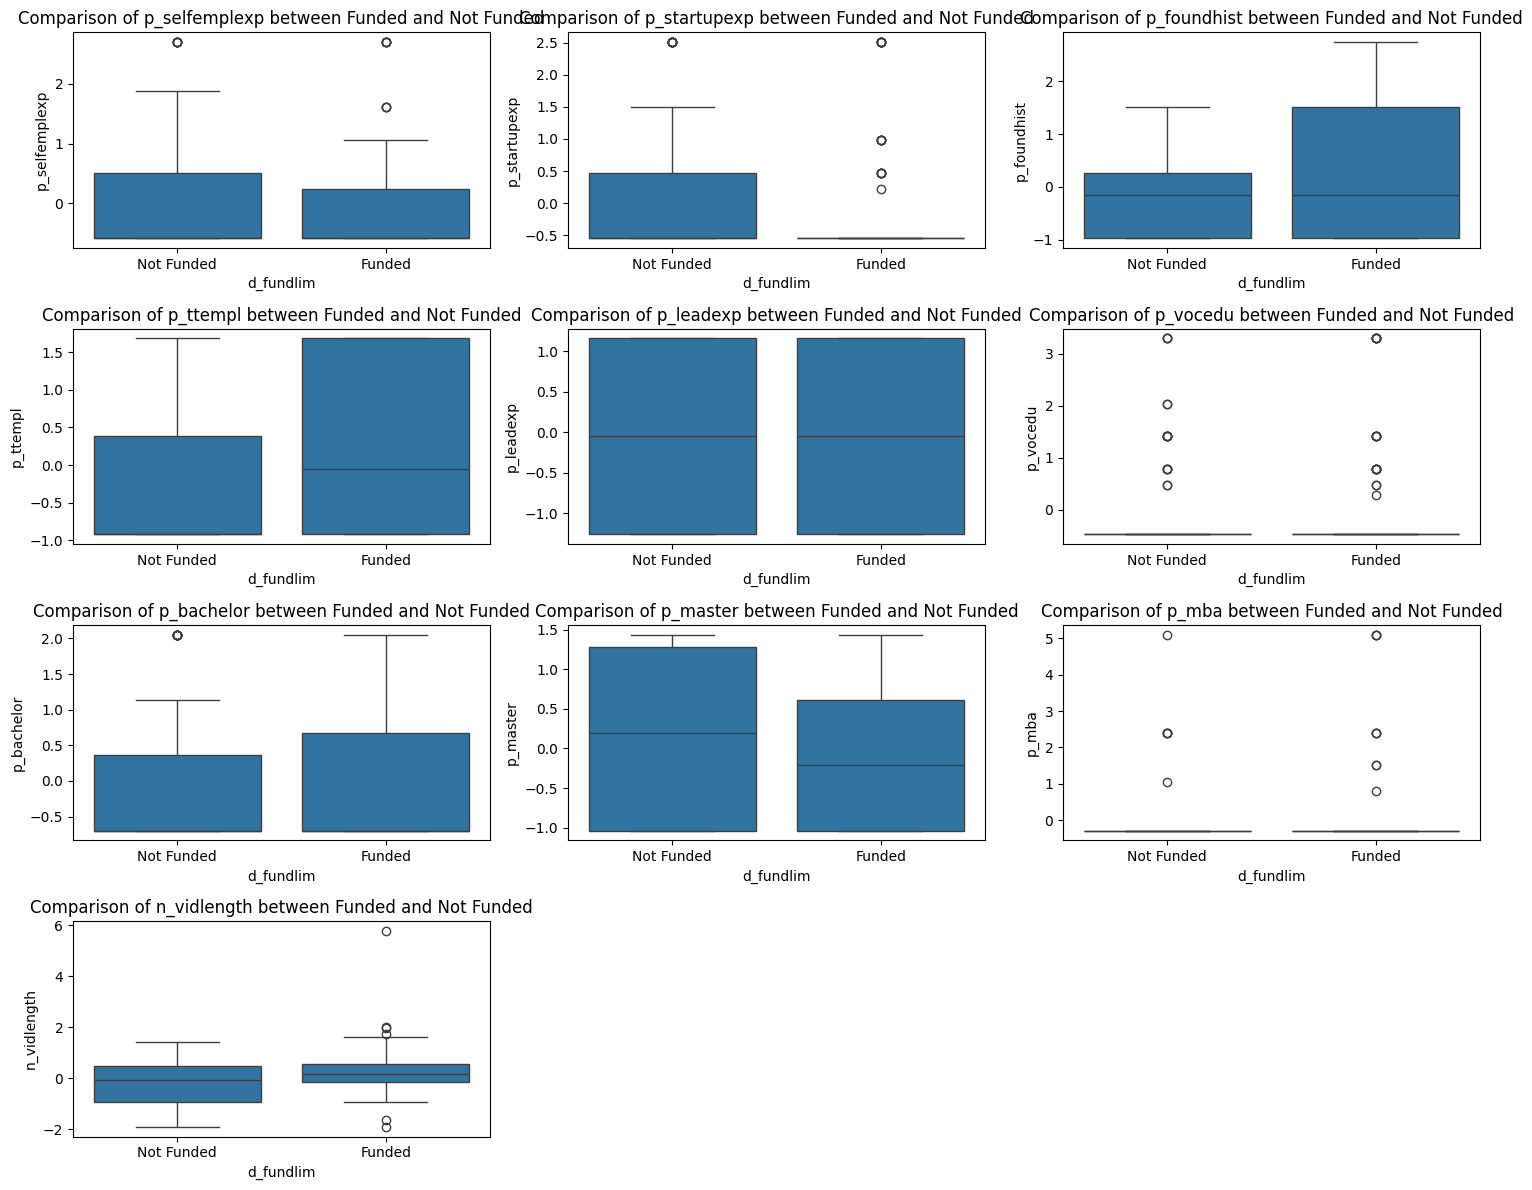

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization: Comparing key variables between funded and not funded start-ups
key_vars = ['p_selfemplexp', 'p_startupexp', 'p_foundhist', 'p_ttempl', 'p_leadexp',
            'p_vocedu', 'p_bachelor', 'p_master', 'p_mba', 'n_vidlength']

plt.figure(figsize=(15, 12))
for i, var in enumerate(key_vars, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='d_fundlim', y=var, data=data)
    plt.title(f'Comparison of {var} between Funded and Not Funded')
    plt.xticks([0, 1], ['Not Funded', 'Funded'])
plt.tight_layout()
plt.show()


In [21]:
marginal_effects = result_all.get_margeff(at='mean')
marginal_effects_summary = marginal_effects.summary_frame()

# Display the marginal effects
print(marginal_effects_summary)


                         dy/dx  Std. Err.         z  Pr(>|z|)  Conf. Int. Low  \
p_selfemplexp         0.009172   0.054662  0.167791  0.866748       -0.097964   
p_startupexp          0.043516   0.057556  0.756066  0.449610       -0.069291   
p_foundhist           0.036230   0.055122  0.657265  0.511010       -0.071807   
p_ttempl              0.040886   0.057139  0.715554  0.474267       -0.071104   
p_leadexp            -0.010351   0.058889 -0.175765  0.860479       -0.125771   
p_femfounder          0.001302   0.054003  0.024108  0.980767       -0.104543   
p_vocedu              0.088783   0.062590  1.418485  0.156049       -0.033891   
p_bachelor           -0.002234   0.076948 -0.029027  0.976843       -0.153049   
p_master             -0.100902   0.082579 -1.221888  0.221750       -0.262754   
p_mba                 0.025912   0.056957  0.454944  0.649150       -0.085721   
p_phd                 0.020757   0.069073  0.300511  0.763787       -0.114623   
p_ttuni               0.0851

In [22]:
import pandas as pd
import statsmodels.api as sm
from itertools import combinations

# Assuming your data is already loaded into `data`
# Define dependent and independent variables
y = data['d_fundlim']
X_base = data.drop(columns=['d_fundlim'])
X_base = sm.add_constant(X_base)

# Initialize a list to store results
interaction_results = []

# Generate all possible pairs of interactions
potential_interactions = list(combinations(X_base.columns[1:], 2))  # Exclude the constant

# Iterate over each interaction term
for var1, var2 in potential_interactions:
    X_temp = X_base.copy()
    # Create the interaction term
    interaction_term = X_temp[var1] * X_temp[var2]
    interaction_name = f'{var1}:{var2}'
    X_temp[interaction_name] = interaction_term
    
    # Fit the logistic regression model with the interaction term
    logit_model = sm.Logit(y, X_temp)
    result = logit_model.fit(disp=0)  # disp=0 suppresses the output
    
    # Extract the p-value for the interaction term
    p_value = result.pvalues[interaction_name]
    
    # Store the interaction term and its p-value
    interaction_results.append((interaction_name, p_value))

# Convert the results to a DataFrame and sort by p-value
interaction_df = pd.DataFrame(interaction_results, columns=['Interaction', 'P-Value'])
interaction_df = interaction_df.sort_values(by='P-Value')

# Display the most significant interactions
print(interaction_df.head(10))  # Show top 10 most significant interactions


/home/mark/my_project/venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mark/my_project/venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mark/my_project/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/mark/my_project/venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mark/my_project/venv/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: ove

                Interaction   P-Value
462    conttype:equityoffer  0.000181
63   p_foundhist:p_bachelor  0.000514
392            d_angel:plat  0.002478
397     d_angel:equityoffer  0.002715
453   year_fund:equityoffer  0.003492
447           plat:conttype  0.004150
58    p_startupexp:comptype  0.005599
288       p_ttuni:year_fund  0.008498
393       d_angel:year_fund  0.014035
226       p_master:d_reward  0.020318


/tmp/ipykernel_13006/3956904578.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y=coef_df.index, data=coef_df, palette="vlag", edgecolor=".2")


AttributeError: module 'matplotlib.pyplot' has no attribute 'ax'

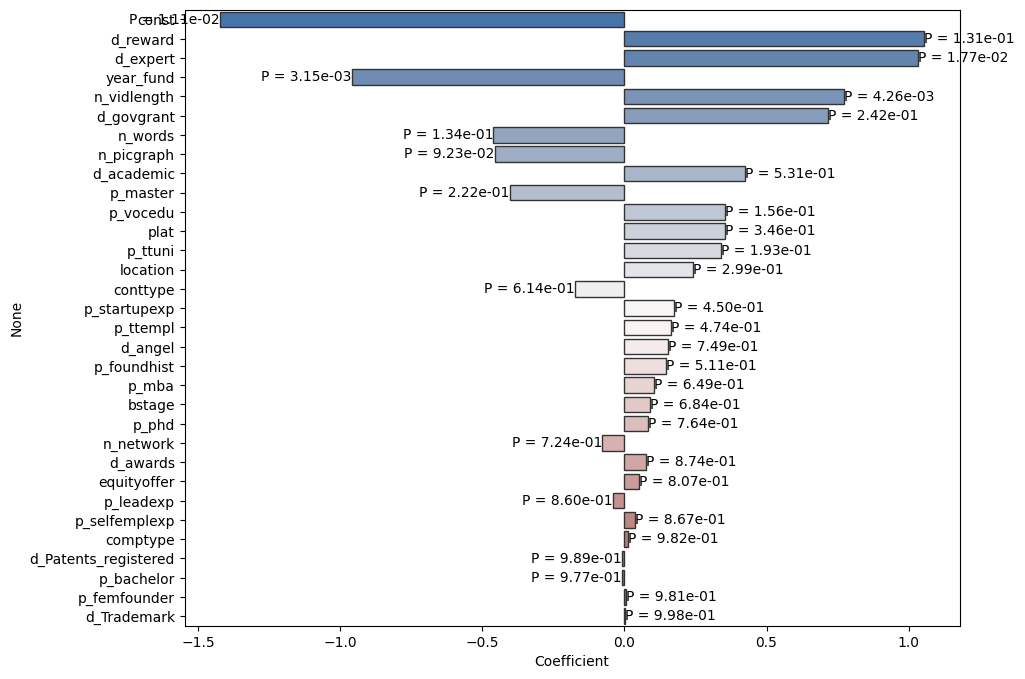

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `result_all` is the result object from your logistic regression model with all variables
coef = result_all.params
p_values = result_all.pvalues

# Create a DataFrame for easy plotting
coef_df = pd.DataFrame({
    'Coefficient': coef,
    'P-Value': p_values
})

# Add a column for the absolute value of the coefficients for better sorting
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sort the coefficients by absolute value
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y=coef_df.index, data=coef_df, palette="vlag", edgecolor=".2")

# Adding significance markers
for i in range(len(coef_df)):
    plt.text(coef_df['Coefficient'][i], i, f"P = {coef_df['P-Value'][i]:.2e}",
             va='center', ha='left' if coef_df['Coefficient'][i] > 0 else 'right',
             color='black', fontsize=10)

plt.ax
